In [6]:
from spyglass.ripple.v1 import RippleTimesV1,RippleParameters
from spyglass.common import interval_list_intersect
import numpy as np

import os
import matplotlib.pyplot as plt
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from ms_opto_stim_protocol import OptoStimProtocol
from Analysis.utils import filter_opto_data
from spyglass.position.v1 import TrodesPosV1


In [27]:
basic_key
from spyglass.position.v1 import TrodesPosV1


## W-track. Run Sessions

In [4]:
ripple_key = {
            "nwb_file_name": nwb_file_name,
            "target_interval_list_name": 
                f"{nwb_file_name}_{interval_list_name}_LFP_default_difference",
        }
RippleTimesV1() & ripple_key

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,group_name,ripple_param_name a name for this set of parameters,pos_merge_id,analysis_file_name name of the file,ripple_times_object_id
f4da42fb-9e40-3ae2-940e-e915b2cf2fd0,Ripple 150-250 Hz,1000,Yoshi20220518_.nwb,Yoshi20220518_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,default_ms,60786e4d-8fe9-c1ec-41ec-448a29b0ef51,Yoshi20220518_ZQZJVX3QFH.nwb,60aad834-ff04-4a69-999a-eb27fe078897


datasets: 19
datasets: 11
datasets: 26
datasets: 16
datasets: 8
datasets: 10
datasets: 8
datasets: 16


Text(0.5, 0.98, 'Ripple Rate During Run epochs')

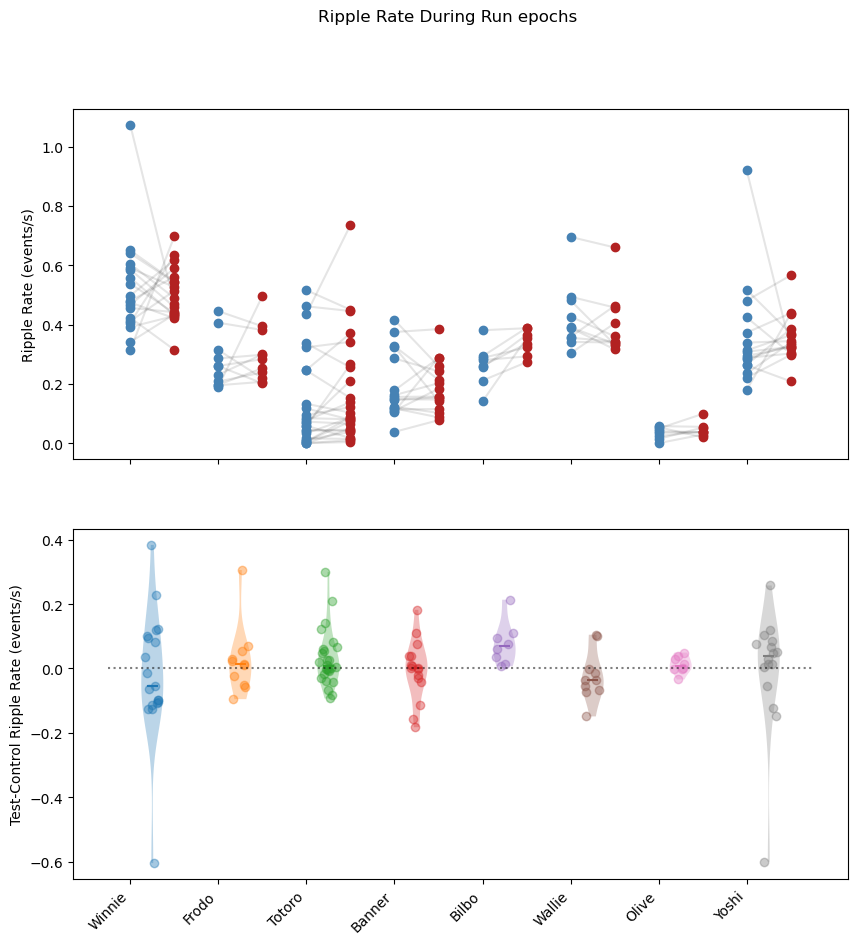

In [7]:
animal_list = [
    "Winnie",
    "Frodo",
    "Totoro",
    "Banner",
    "Bilbo",
    "Wallie",
    "Olive",
    "Yoshi",
]
filter_speed = True

fig, ax = plt.subplots(figsize=(10, 10), nrows=2, sharex=True)

for loc, animal in enumerate(animal_list):
    dataset_key = {
        "animal": animal,
        #    "period_ms":80,
        "min_pulse_length": 20,
        "track_type": "wtrack",
    }

    dataset = filter_opto_data(
        dataset_key,
    )
    nwb_file_names = dataset.fetch("nwb_file_name")
    interval_list_names = dataset.fetch("interval_list_name")

    test_ripple_rate = []
    control_ripple_rate = []
    for nwb_file_name, interval_list_name in zip(nwb_file_names, interval_list_names):
        basic_key = {
            "nwb_file_name": nwb_file_name,
            "interval_list_name": interval_list_name,
        }
        ripple_key = {
            "nwb_file_name": nwb_file_name,
            "target_interval_list_name":
                f"{nwb_file_name}_{interval_list_name}_LFP_default_difference",
        }
        if not RippleTimesV1() & ripple_key:
            print("No ripples for {}".format(ripple_key))
            continue

        ripple_df = (RippleTimesV1() & ripple_key).fetch1_dataframe()
        all_ripples = [
            [start, end] for start, end in zip(ripple_df.start_time, ripple_df.end_time)
        ]
        control_intervals = (OptoStimProtocol & basic_key).fetch1("control_intervals")
        test_intervals = (OptoStimProtocol & basic_key).fetch1("test_intervals")

        control_ripples = interval_list_intersect(
            np.array(all_ripples), np.array(control_intervals)
        )
        test_ripples = interval_list_intersect(
            np.array(all_ripples), np.array(test_intervals)
        )
        
        #filter times when rat is stationary for rate calculation
        if filter_speed:
            #get the threshold speed from the ripple calculation
            ripple_param_name = (RippleTimesV1() & ripple_key).fetch1("ripple_param_name")
            thresh_speed = (RippleParameters() & {"ripple_param_name": ripple_param_name}).fetch1(
                "ripple_param_dict"
            )["ripple_detection_params"]["speed_threshold"]
            #get the speed over time
            pos_df = (TrodesPosV1() & basic_key & {"trodes_pos_params_name": "single_led"}).fetch1_dataframe()
            pos_time = pos_df.index.values
            pos_speed = pos_df.speed.values
            # make intervals where rat is stationary
            speed_binary = (pos_speed < thresh_speed).astype(int)
            speed_binary = np.append([0], speed_binary)
            if np.min(speed_binary) == 1:
                run_intervals = [(pos_time[0], pos_time[-1])]
            t_diff = np.diff(speed_binary)
            t_run_start = pos_time[np.where(t_diff == 1)[0]]
            t_run_stop = pos_time[np.where(t_diff == -1)[0]]
            stationary_intervals = [(start, stop) for start, stop in zip(t_run_start, t_run_stop)]
            # restrict the intervals by this
            control_intervals = interval_list_intersect(
                np.array(control_intervals), np.array(stationary_intervals)
            )
            test_intervals = interval_list_intersect(
                np.array(test_intervals), np.array(stationary_intervals)
            )
            
        test_ripple_lengths = [end - start for start, end in test_ripples]
        control_ripple_lengths = [end - start for start, end in control_ripples]

        len_test = np.sum([end - start for start, end in test_intervals])
        len_control = np.sum([end - start for start, end in control_intervals])

        test_ripple_rate.append(len(test_ripple_lengths) / len_test)
        control_ripple_rate.append(len(control_ripple_lengths) / len_control)

    if len(test_ripple_rate) == 0:
        continue
    ax[0].scatter(
        np.ones(len(test_ripple_rate)) * 2 * loc + 1,
        test_ripple_rate,
        color="firebrick",
    )
    ax[0].scatter(
        np.ones(len(control_ripple_rate)) * 2 * loc,
        control_ripple_rate,
        color="steelblue",
    )
    for test, control in zip(test_ripple_rate, control_ripple_rate):
        ax[0].plot(
            [2 * loc, 2 * loc + 1], [control, test], color="black", alpha=0.1, zorder=-1
        )

    ax[1].violinplot(
        [np.array(test_ripple_rate) - np.array(control_ripple_rate)],
        positions=[2 * loc + 0.5],
        showmedians=True,
        showextrema=False,
    )
    ax[1].scatter(
        2 * loc
        + 0.5 * np.ones(len(test_ripple_rate))
        + np.random.normal(0, 0.1, len(test_ripple_rate)),
        np.array(test_ripple_rate) - np.array(control_ripple_rate),
        alpha=0.4,
    )

plt.xticks(2 * np.arange(len(animal_list)), animal_list, rotation=45, ha="right")
plt.plot([-0.5, 2 * len(animal_list) - 0.5], [0, 0], color="black", ls=":", alpha=0.5)
ax[0].set_ylabel("Ripple Rate (events/s)")
ax[1].set_ylabel("Test-Control Ripple Rate (events/s)")
fig.suptitle("Ripple Rate During Run epochs")

In [107]:
len(all_ripples) == len(test_ripples) + len(control_ripples)

True

## W-track sleeps epochs

datasets: 19
datasets: 11
No ripples for {'nwb_file_name': 'Frodo20230815_.nwb', 'target_interval_list_name': 'Frodo20230815_.nwb_pos 4 valid times_LFP_default_difference'}
No ripples for {'nwb_file_name': 'Frodo20230815_.nwb', 'target_interval_list_name': 'Frodo20230815_.nwb_pos 5 valid times_LFP_default_difference'}
datasets: 26
datasets: 8
datasets: 10
datasets: 8
datasets: 16


Text(0.5, 1.0, 'Ripple Rate During Sleep epochs')

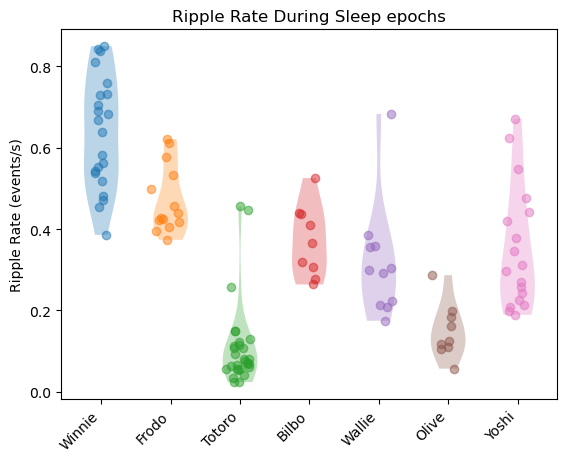

In [8]:
from spyglass.common import PositionIntervalMap,IntervalList
from spyglass.position.v1 import TrodesPosV1
animal_list = [
    "Winnie",
    "Frodo",
    "Totoro",
    # "Banner",
    "Bilbo",
    "Wallie",
    "Olive",
    "Yoshi",
]
filter_speed = True


for loc, animal in enumerate(animal_list):
    dataset_key = {'animal':animal,
                #    "period_ms":80,
                "min_pulse_length":20,
                "track_type":'wtrack'
                
                }


    # get sleep interval sets
    dataset = filter_opto_data(dataset_key,)
    nwb_file_set = np.unique(dataset.fetch("nwb_file_name"))
    nwb_file_names = []
    interval_list_names = []
    for nwb_file_name in nwb_file_set:
        sleep_interval_names = (PositionIntervalMap & {'nwb_file_name':nwb_file_name,
                            } & "interval_list_name LIKE '%sleep%'").fetch("position_interval_name")
        for interval in sleep_interval_names:
            nwb_file_names.append(nwb_file_name)
            interval_list_names.append(interval)
            
    ripple_rate = []
    for nwb_file_name, interval_list_name in zip(nwb_file_names, interval_list_names):
        ripple_key = {"nwb_file_name":nwb_file_name,
                    "target_interval_list_name":
                        f"{nwb_file_name}_{interval_list_name}_LFP_default_difference"#interval_list_name,}
        }
        basic_key = {"nwb_file_name":nwb_file_name,
                    "interval_list_name":interval_list_name,}
        if not RippleTimesV1() & ripple_key:
            print("No ripples for {}".format(ripple_key))
            continue
        


        ripple_df = (RippleTimesV1() & ripple_key).fetch1_dataframe()
        all_ripples = [[start, end] for start, end in zip(ripple_df.start_time, ripple_df.end_time)]
        
        valid_times = (IntervalList & basic_key).fetch1('valid_times')
        #filter times when rat is stationary for rate calculation
        if filter_speed:
            #get the threshold speed from the ripple calculation
            ripple_param_name = (RippleTimesV1() & ripple_key).fetch1("ripple_param_name")
            thresh_speed = (RippleParameters() & {"ripple_param_name": ripple_param_name}).fetch1(
                "ripple_param_dict"
            )["ripple_detection_params"]["speed_threshold"]
            #get the speed over time
            pos_df = (TrodesPosV1() & basic_key & {"trodes_pos_params_name": "single_led"}).fetch1_dataframe()
            pos_time = pos_df.index.values
            pos_speed = pos_df.speed.values
            # make intervals where rat is stationary
            speed_binary = (pos_speed < thresh_speed).astype(int)
            speed_binary = np.append([0], speed_binary)
            if np.min(speed_binary) == 1:
                run_intervals = [(pos_time[0], pos_time[-1])]
            t_diff = np.diff(speed_binary)
            t_run_start = pos_time[np.where(t_diff == 1)[0]]
            t_run_stop = pos_time[np.where(t_diff == -1)[0]]
            stationary_intervals = [(start, stop) for start, stop in zip(t_run_start, t_run_stop)]
            # restrict the intervals by this
            valid_times = interval_list_intersect(
                np.array(valid_times), np.array(stationary_intervals)
            )
        len_sleep = np.sum([end-start for start, end in valid_times])
        ripple_rate.append(len(all_ripples)/len_sleep)
    
    if not ripple_rate:
        continue       
    plt.violinplot(ripple_rate, positions=[loc], showextrema=False, widths=.5)
    plt.scatter(np.ones(len(ripple_rate))*loc+np.random.normal(0,.1,len(ripple_rate)), ripple_rate, alpha=.5)
    

plt.xticks(np.arange(len(animal_list)), animal_list, rotation=45, ha='right')
plt.ylabel("Ripple Rate (events/s)")
plt.title("Ripple Rate During Sleep epochs")

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f1ca0803df0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f1ca07fb040>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f1c927e86a0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f1c927e8a90>}

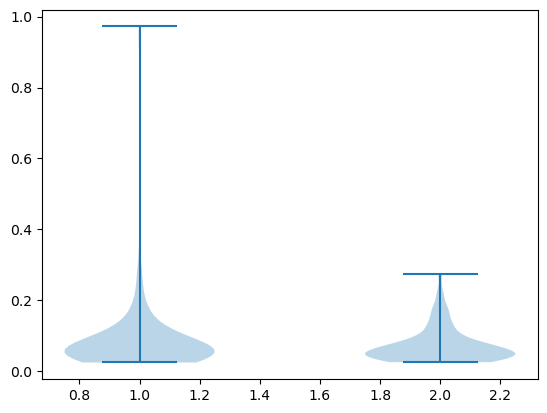

In [9]:
test_ripple_lengths = [end-start for start, end in test_ripples]
control_ripple_lengths = [end-start for start, end in control_ripples]

len_test = np.sum([end-start for start, end in test_intervals])
len_control = np.sum([end-start for start, end in control_intervals])
import matplotlib.pyplot as plt
plt.violinplot([test_ripple_lengths, control_ripple_lengths])